In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/xray.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp1') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
# useful for getting number of classes

folders = glob('/tmp1/xray/train/*')

print(type(folders))
print(folders)
len(folders)

<class 'list'>
['/tmp1/xray/train/NORMAL', '/tmp1/xray/train/PNEUMONIA']


2

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras import optimizers
import tensorflow as tf


adam = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
#training data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#validation data augmentation
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory('/tmp1/xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory('/tmp1/xray/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4708 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='xray_vgg.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=valid_set,
  epochs=10,
  steps_per_epoch=len(train_set),
  validation_steps=len(valid_set),
    callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.48186, saving model to xray_vgg.h5
148/148 - 150s - loss: 0.4884 - accuracy: 0.7672 - val_loss: 0.4819 - val_accuracy: 0.7424 - 150s/epoch - 1s/step
Epoch 2/10

Epoch 00002: val_loss improved from 0.48186 to 0.25618, saving model to xray_vgg.h5
148/148 - 146s - loss: 0.3330 - accuracy: 0.8449 - val_loss: 0.2562 - val_accuracy: 0.8912 - 146s/epoch - 986ms/step
Epoch 3/10

Epoch 00003: val_loss improved from 0.25618 to 0.24636, saving model to xray_vgg.h5
148/148 - 146s - loss: 0.3020 - accuracy: 0.8600 - val_loss: 0.2464 - val_accuracy: 0.8969 - 146s/epoch - 984ms/step
Epoch 4/10

Epoch 00004: val_loss did not improve from 0.24636
148/148 - 143s - loss: 0.3052 - accuracy: 0.8628 - val_loss: 0.3102 - val_accuracy: 0.8874 - 143s/epoch - 967ms/step
Epoch 5/10

Epoch 00005: val_loss did not improve from 0.24636
148/148 - 144s - loss: 0.3808 - accuracy: 0.8369 - val_loss: 0.3942 - val_accuracy: 0.8473 - 144s/epoch - 971ms/step
Epoch 6/

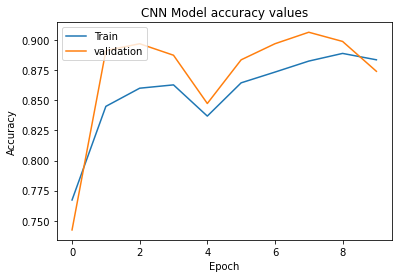

In [ ]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

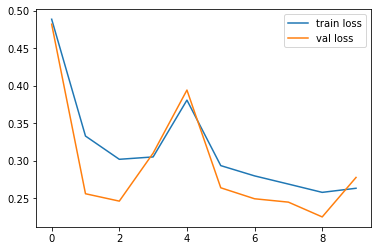

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
from keras.models import load_model
vgg16_xray = load_model('xray_vgg.h5')

In [ ]:
test_gen= ImageDataGenerator(rescale = 1./255)
test_set=test_gen.flow_from_directory('/tmp1/xray/test', target_size=(224, 224), shuffle=False)
steps_per_epoch_test=len(test_set)

Found 624 images belonging to 2 classes.


In [ ]:
t = vgg16_xray.evaluate_generator(test_set, steps_per_epoch_test, verbose=1)
#print("accuracy fortesting is :....", test_history[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


20/20 [==============================] - 8s 344ms/step - loss: 0.3382 - accuracy: 0.8590
